# Afín: 3 puntos **no colineales** vs **colineales** 




Imagen cargada OK: (512, 512)


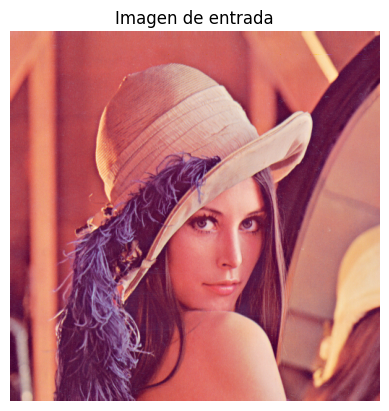

In [4]:
import cv2, numpy as np, matplotlib.pyplot as plt, os

# 🔧 Cambia esta ruta a la ubicación real de tu imagen si es necesario
IMG_PATH = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\lenna.png"

# Carga segura con mensajes claros
img_bgr = cv2.imread(IMG_PATH)
if img_bgr is None:
    raise FileNotFoundError(
        f"No se pudo cargar la imagen desde:\n{IMG_PATH}\n"
        "➡️ Verifica la ruta. Si no tienes lenna.png, usa cualquier imagen y actualiza IMG_PATH."
    )

img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
print("Imagen cargada OK:", (w, h))
plt.imshow(img); plt.title("Imagen de entrada"); plt.axis("off"); plt.show()

def draw_points(im, pts, color=(255,0,0)):
    out = im.copy()
    for i,(x,y) in enumerate(pts.astype(int)):
        cv2.circle(out, (x,y), 6, color, -1)
        cv2.putText(out, f"P{i+1}", (x+6,y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return out

def affine_from_3pts(src3, dst3):
    """
    Método geométrico: A = B' B^{-1},  t = P1' - A P1
    Devuelve (A,t,detB,condB). Si B no es invertible, devuelve None en A,t.
    """
    P1, P2, P3 = src3
    P1p, P2p, P3p = dst3
    B  = np.column_stack([(P2-P1), (P3-P1)]).astype(float)     # 2x2
    Bp = np.column_stack([(P2p-P1p), (P3p-P1p)]).astype(float) # 2x2
    detB = float(np.linalg.det(B))
    try:
        condB = float(np.linalg.cond(B))
    except np.linalg.LinAlgError:
        condB = float('inf')
    if abs(detB) < 1e-12:
        return None, None, detB, condB
    A = Bp @ np.linalg.inv(B)
    t = P1p - A @ P1
    return A, t, detB, condB

def warp_affine(img, A, t, size=None):
    if size is None:
        size = (img.shape[1], img.shape[0])
    M = np.hstack([A, t.reshape(2,1)]).astype(np.float32)
    return cv2.warpAffine(img, M, size, flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))


## Caso A — 3 puntos **no colineales** 
los puntos definen un triángulo con área ≠ 0.


Caso A — no colineales
det(B) = 7.864320e+04   cond(B) ≈ 1.29


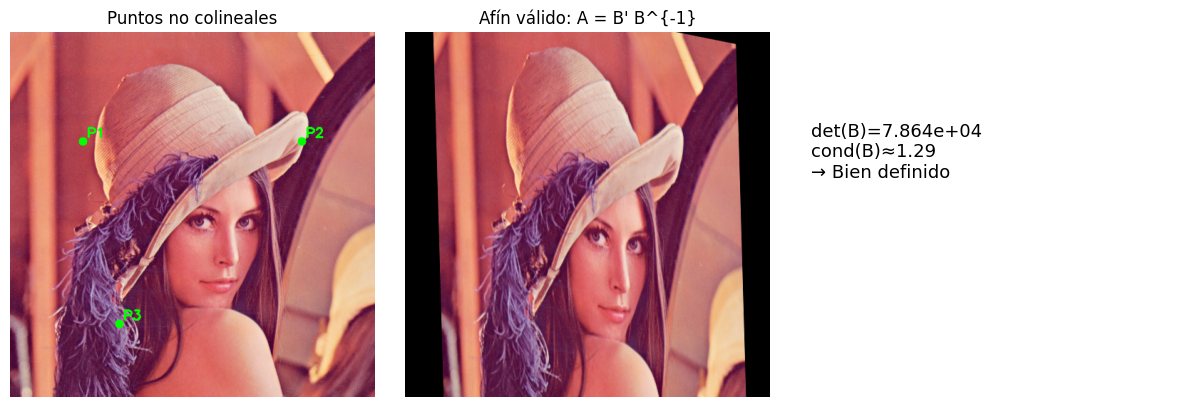

In [5]:
src3_A = np.float32([[0.20*w, 0.30*h],
                     [0.80*w, 0.30*h],
                     [0.30*w, 0.80*h]])
dst3_A = np.float32([[0.25*w, 0.25*h],
                     [0.75*w, 0.35*h],
                     [0.35*w, 0.85*h]])

A_A, t_A, detA, condA = affine_from_3pts(src3_A, dst3_A)
print("Caso A — no colineales")
print(f"det(B) = {detA:.6e}   cond(B) ≈ {condA:.2f}")
img_pts_A = draw_points(img, src3_A, (0,255,0))

if A_A is not None:
    warp_A = warp_affine(img, A_A, t_A, (w, h))
else:
    warp_A = np.zeros_like(img)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_pts_A); plt.title("Puntos no colineales"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(warp_A);   plt.title("Afín válido: A = B' B^{-1}"); plt.axis("off")
plt.subplot(1,3,3); plt.text(0.05,0.6, f"det(B)={detA:.3e}\ncond(B)≈{condA:.2f}\n→ Bien definido", fontsize=13)
plt.gca().axis('off')
plt.tight_layout(); plt.show()


## Caso B — 3 puntos **colineales** 



Caso B — colineales
det(B) = 0.000000e+00   cond(B) ≈ inf


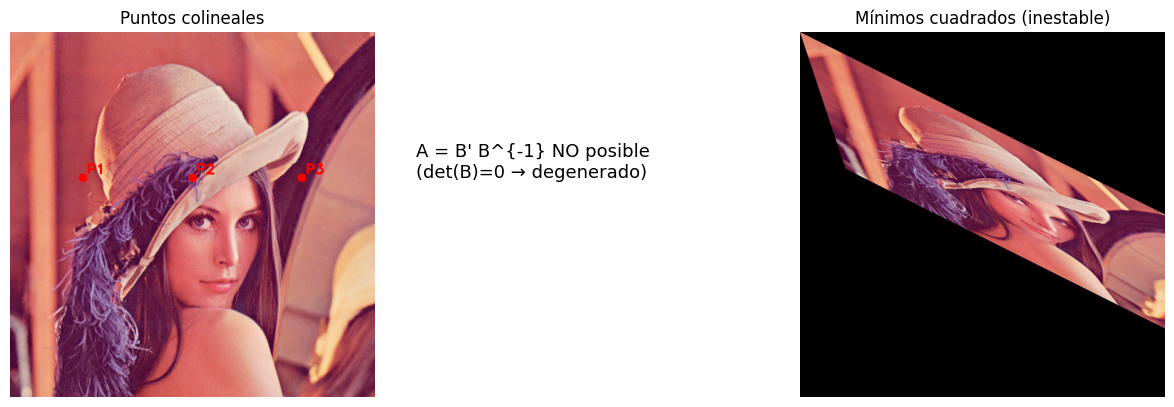

In [6]:
y_line = 0.40*h
src3_B = np.float32([[0.20*w, y_line],
                     [0.50*w, y_line],
                     [0.80*w, y_line]])
dst3_B = np.float32([[0.25*w, 0.25*h],
                     [0.55*w, 0.40*h],
                     [0.85*w, 0.55*h]])

A_B, t_B, detB, condB = affine_from_3pts(src3_B, dst3_B)
print("\nCaso B — colineales")
print(f"det(B) = {detB:.6e}   cond(B) ≈ {condB:.2f}")
img_pts_B = draw_points(img, src3_B, (255,0,0))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_pts_B); plt.title("Puntos colineales"); plt.axis("off")
if A_B is None:
    plt.subplot(1,3,2); plt.text(0.05,0.6,"A = B' B^{-1} NO posible\n(det(B)=0 → degenerado)", fontsize=13)
    plt.gca().axis('off')
else:
    warp_B = warp_affine(img, A_B, t_B, (w, h))
    plt.subplot(1,3,2); plt.imshow(warp_B); plt.title("Afín (geométrico)"); plt.axis("off")

# Intento ilustrativo: mínimos cuadrados (no único, potencialmente inestable)
def solve_lstsq(src3, dst3):
    A_ls = []; b_ls = []
    for (x,y),(xp,yp) in zip(src3, dst3):
        A_ls.append([x,y,1, 0,0,0]); b_ls.append(xp)
        A_ls.append([0,0,0, x,y,1]); b_ls.append(yp)
    A_ls = np.asarray(A_ls, float)
    b_ls = np.asarray(b_ls, float)
    p, *_ = np.linalg.lstsq(A_ls, b_ls, rcond=None)
    a11,a12,tx,a21,a22,ty = p
    A = np.array([[a11,a12],[a21,a22]], float)
    t = np.array([tx,ty], float)
    return A,t

A_B_ls, t_B_ls = solve_lstsq(src3_B, dst3_B)
warp_B_ls = warp_affine(img, A_B_ls, t_B_ls, (w, h))
plt.subplot(1,3,3); plt.imshow(warp_B_ls); plt.title("Mínimos cuadrados (inestable)"); plt.axis("off")
plt.tight_layout(); plt.show()


### Conclusiones
- Con **3 puntos no colineales**, la afín está **bien determinada** y el warp es consistente.  
- Con **3 puntos colineales**, `det(B)=0` → la afín **no es única**. Cualquier solución que encuentres (p.ej. por mínimos cuadrados) es **una entre infinitas** y puede ser **inestable**.  
- En práctica, evita puntos colineales; si dudas, revisa el **determinante** y el **número de condición**.
